# Introducción a Detectron2 con Kaggle

Detectron2 es un framework de **Facebook AI Research (FAIR)** para tareas avanzadas de visión por computador, como:

- **Detección de objetos (Object Detection)** → localizar y clasificar objetos en una imagen.  
- **Segmentación de instancias (Instance Segmentation)** → no solo detectar, sino también delinear la forma del objeto.  
- **Detección de keypoints (Keypoint Detection)** → por ejemplo, articulaciones del cuerpo humano.  
- **Segmentación panóptica (Panoptic Segmentation)** → combinación de segmentación de instancias y semántica.  

---

## Objetivo del notebook
En este notebook vamos a realizar un **fine-tuning** de Detectron2 usando un dataset pequeño.  
Esto significa que:
- Partimos de un modelo ya entrenado en **COCO dataset**.  
- Lo ajustamos para detectar **nuevas clases** con un dataset más reducido.  

Esto es mucho más eficiente que entrenar desde cero y es la práctica más común en proyectos reales.  

![image.png](attachment:6be333c1-63cd-4558-b2bc-eaf1f0922ae5.png)![image.png](attachment:8f58a024-a4b0-460c-b493-e626faf9f122.png)

In [25]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-9ib2glua
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-9ib2glua
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done


# Fase 1: Setup e instalación de Detectron2

In [26]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [27]:
!wget http://images.cocodataset.org/val2017/000000282037.jpg -q -O input.jpg

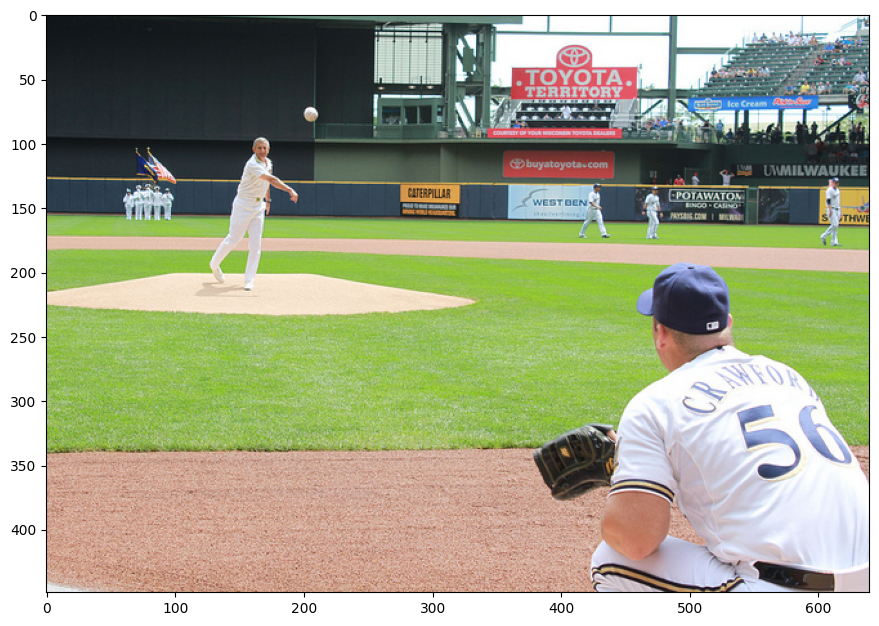

In [28]:
im = cv2.imread("./input.jpg")

plt.figure(figsize=(15,7.5))
plt.imshow(im[..., ::-1])

# Fase 2: Cargar y registrar el dataset

Para este ejercicio práctico vamos a usar el **Balloon Dataset**, un conjunto pequeño de imágenes de globos con anotaciones.

¿Por qué este dataset?
- Es liviano y rápido de descargar.
- Ya está en formato COCO (compatible con Detectron2).
- Perfecto para mostrar un **fine-tuning** sin tardar horas.


In [29]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im[..., ::-1])

print(outputs["instances"].pred_classes)

[09/19 04:44:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
tensor([ 0,  0,  0,  0,  0, 35, 32,  0,  0,  0,  0,  0], device='cuda:0')


In [30]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

namespace(name='coco_2017_train',
          json_file='datasets/coco/annotations/instances_train2017.json',
          image_root='datasets/coco/train2017',
          evaluator_type='coco',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             13: 11,
                                             14: 12,
                                             15: 13,
                                             16: 14,
                                   

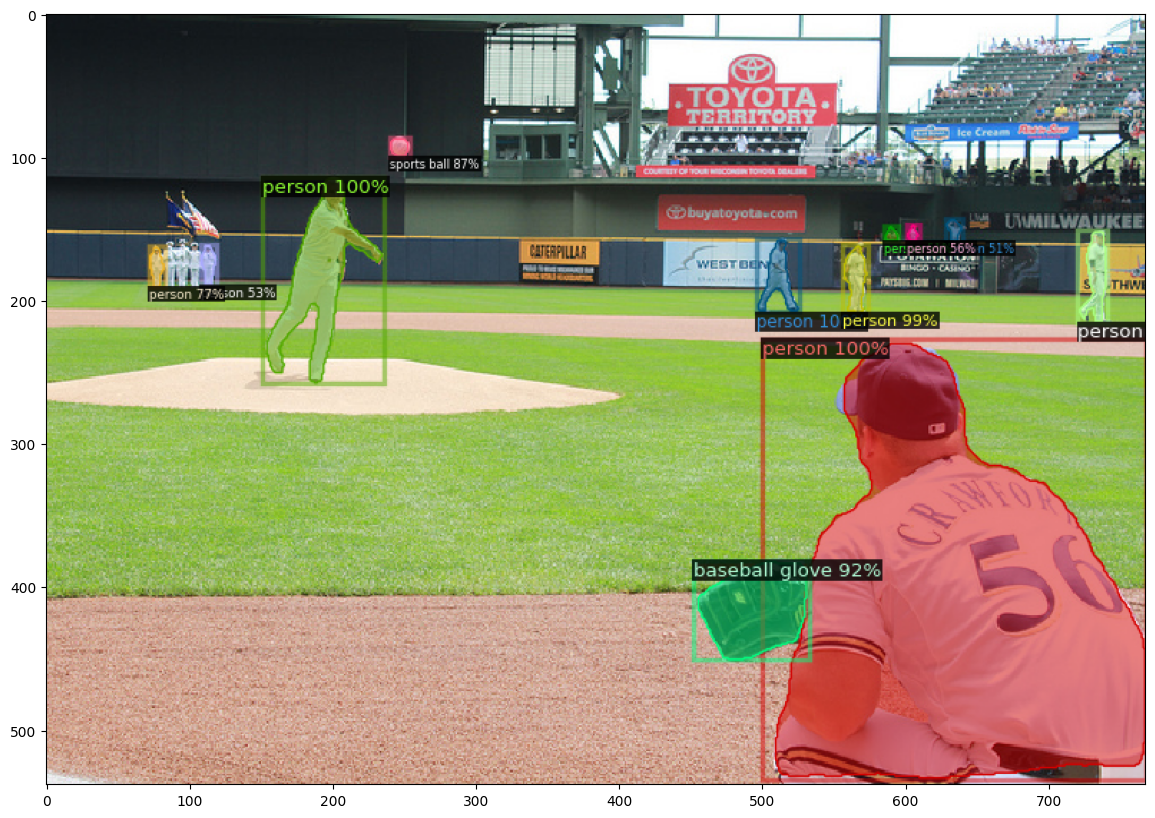

In [31]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(out.get_image()[..., ::-1][..., ::-1])

In [32]:
import os
import urllib.request
import zipfile

url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
zip_path = "balloon_dataset.zip"

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

print("Extracted content in:", os.listdir("."))

Extracted content in: ['.config', '__MACOSX', 'balloon_dataset.zip', 'output', 'input.jpg', 'balloon', 'sample_data']


In [33]:
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

AssertionError: Dataset 'balloon_train' is already registered!

In [45]:
def get_balloon_dicts_half(img_dir, frac=0.5, seed=42):
    data = get_balloon_dicts(img_dir)      # reuse your existing loader
    rng = random.Random(seed)
    rng.shuffle(data)
    k = int(len(data) * frac)
    return data[:k]

# keep full val; use half for train
DatasetCatalog.register(
    "balloon_train_half",
    lambda: get_balloon_dicts_half("balloon/train", frac=0.5, seed=42)
)
MetadataCatalog.get("balloon_train_half").set(thing_classes=["balloon"])

AssertionError: Dataset 'balloon_train_half' is already registered!

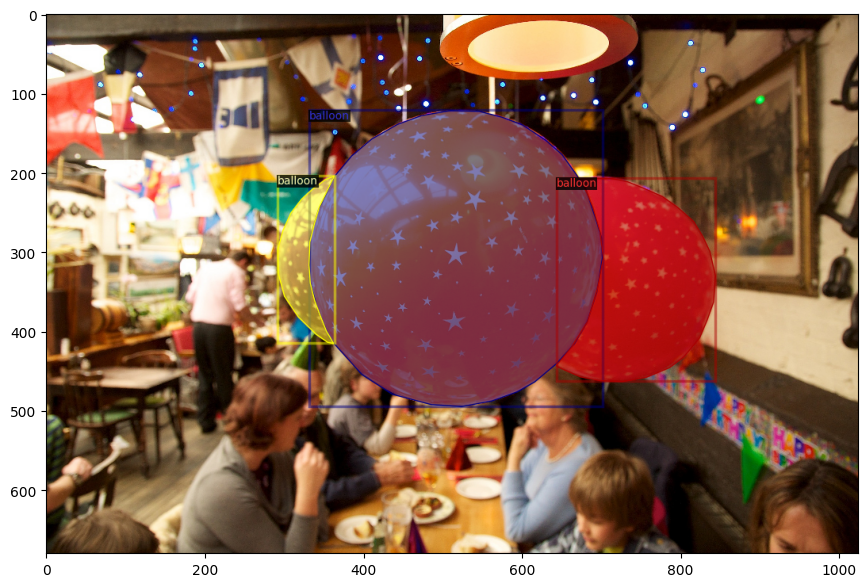

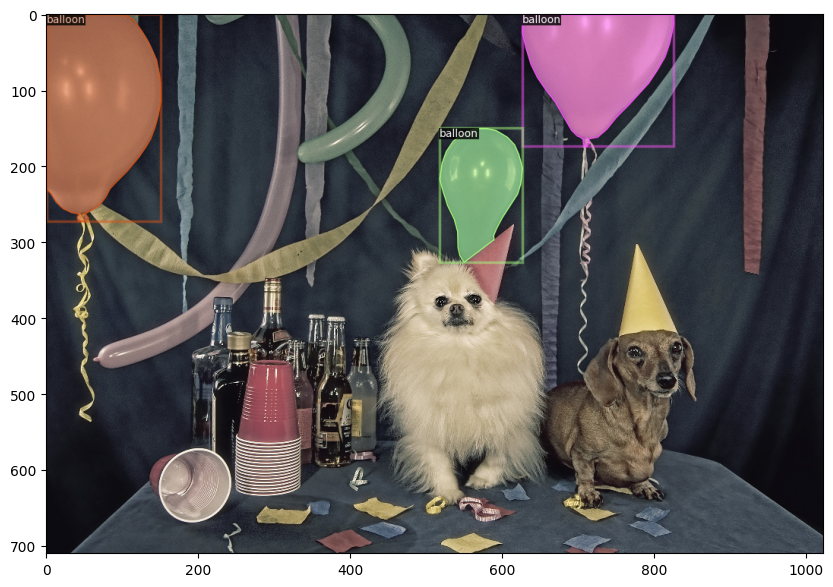

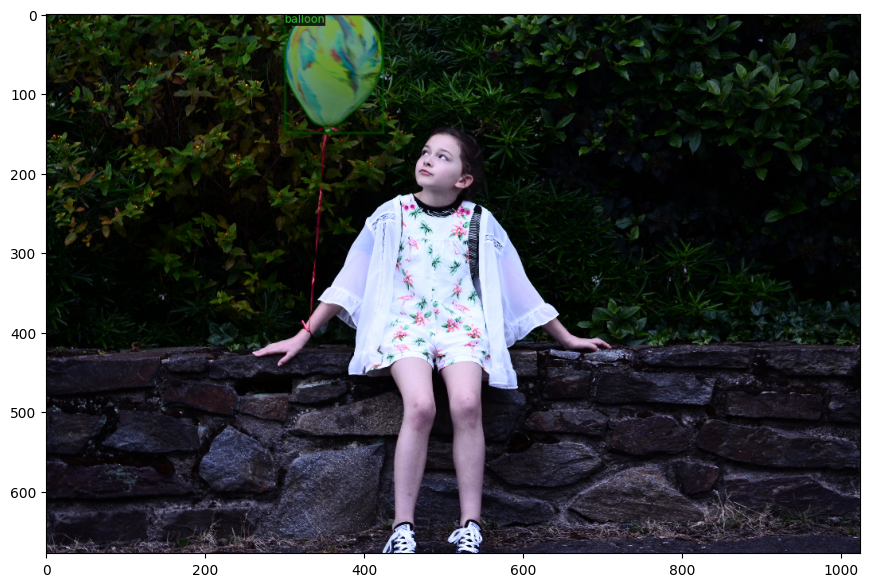

In [46]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

# Fase 3: Configuración del modelo y Fine-Tuning

En esta fase vamos a:

1. Cargar un modelo preentrenado de Detectron2 (Mask R-CNN con ResNet-50 + FPN entrenado en COCO).  
2. Ajustarlo para detectar nuestra clase "balloon".  
3. Configurar hiperparámetros clave: learning rate, batch size, número de iteraciones.  
4. Entrenar el modelo usando **fine-tuning**, aprovechando que ya viene preentrenado.

In [52]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00075
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/19 05:29:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/19 05:29:11 d2.engine.train_loop]: Starting training from iteration 0
[09/19 05:29:22 d2.utils.events]:  eta: 0:04:03  iter: 19  total_loss: 2.134  loss_cls: 0.731  loss_box_reg: 0.6446  loss_mask: 0.6788  loss_rpn_cls: 0.02487  loss_rpn_loc: 0.00778    time: 0.5006  last_time: 0.5102  data_time: 0.0306  last_data_time: 0.0066   lr: 2.9221e-05  max_mem: 2970M
[09/19 05:29:31 d2.utils.events]:  eta: 0:03:47  iter: 39  total_loss: 1.728  loss_cls: 0.5183  loss_box_reg: 0.5461  loss_mask: 0.5357  loss_rpn_cls: 0.04311  loss_rpn_loc: 0.00526    time: 0.4873  last_time: 0.4078  data_time: 0.0097  last_data_time: 0.0056   lr: 5.9192e-05  max_mem: 2970M
[09/19 05:29:41 d2.utils.events]:  eta: 0:03:35  iter: 59  total_loss: 1.571  loss_cls: 0.4084  loss_box_reg: 0.6706  loss_mask: 0.4001  loss_rpn_cls: 0.02709  loss_rpn_loc: 0.007955    time: 0.4832  last_time: 0.4232  data_time: 0.0161  last_data_time: 0.0364   lr: 8.9161e-05  max_mem: 2970M
[09/19 05:29:51 d2.utils.events]:  eta: 0:03:26

[09/19 05:49:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


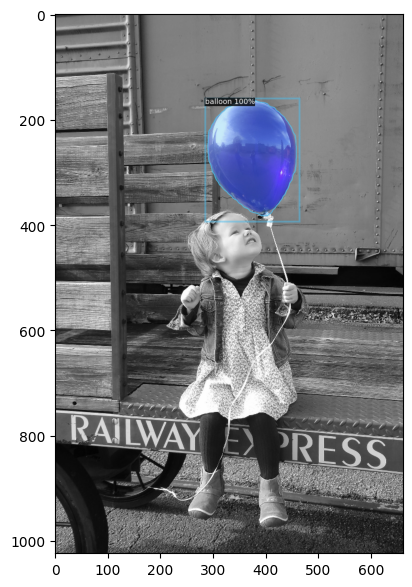

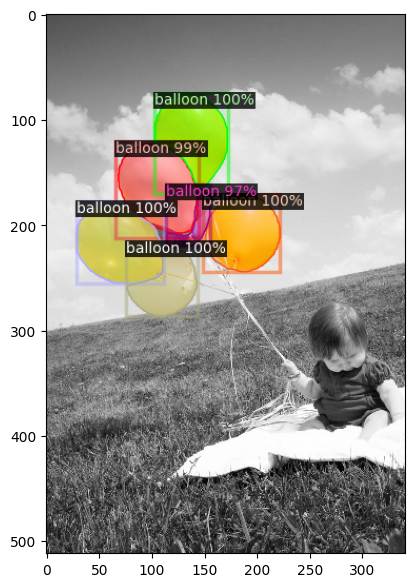

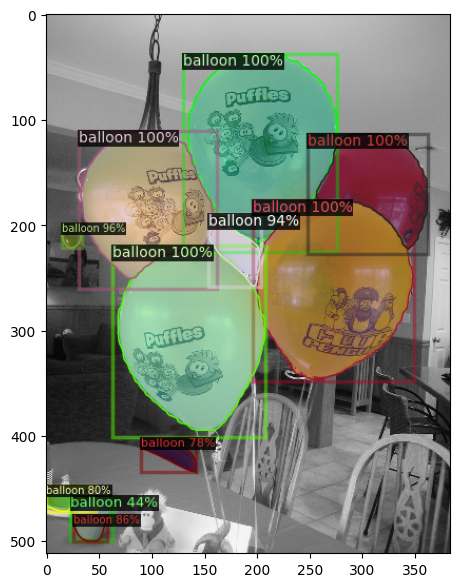

In [64]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

## Test

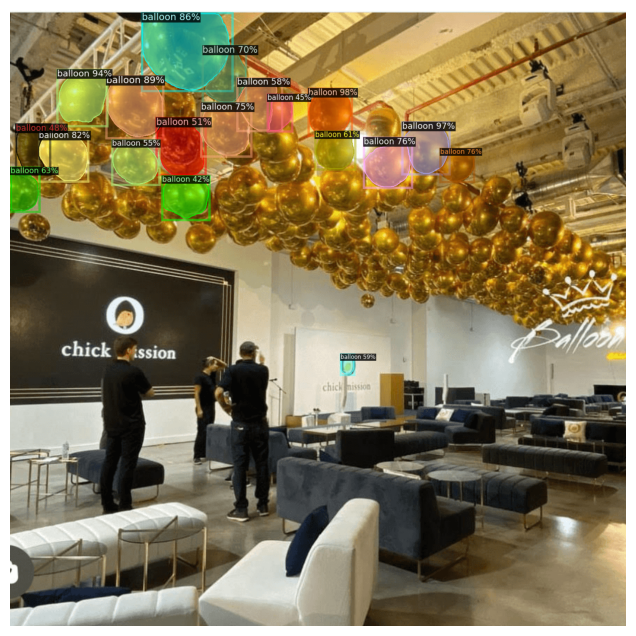

In [65]:
import requests
from io import BytesIO
image_url = "https://cdn11.bigcommerce.com/s-af2f8xc7r2/images/stencil/1280w/uploaded_images/balloon-kings-nj.png"
response = requests.get(image_url)
image_bytes = BytesIO(response.content)
im = np.array(cv2.imdecode(np.frombuffer(image_bytes.read(), np.uint8), cv2.IMREAD_COLOR))

if im is None:
    raise ValueError("It didn't load the image")

outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(10, 8))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()


## Exercises

1. Reduce the number of training examples by half. Compare training time, predictions, and loss.

2. Increase the learning rate and analyze the results.

3. Modify the test threshold to make a better prediction

4. Increase the maximum number of iterations and note the impact.

5. Test with your own image and summarize your observations.